## Punctate metric is biasing genes with fewer spots per cell to have more punctate scores

Same issue with radial metric

Definitely occuring when the number of spots, m = 1

Not sure actually if this is occuring when m > 1, but I'll test that now

I've added a method to the Cell class to filter out genes with counts below a threshold

In [57]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting

importlib.reload(SRRS)
importlib.reload(metrics)
importlib.reload(scoring)
importlib.reload(plotting)

sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
sample.num_cells

152

In [58]:
%%time
#fast
unfilt_cells = [c for c in sample.iter_cells() if c.n > 300]
unfilt_scored_cells = list(scoring._iter_scores(unfilt_cells, metric_name='radial', processes=3))

len(unfilt_scored_cells)

CPU times: user 2.03 s, sys: 82 ms, total: 2.12 s
Wall time: 2.8 s


73

In [59]:
%%time

#slow since gene_vars need to be recalculated
min_gene_spots = 2
filt_cells = [c.filter_low_count_genes(min_gene_spots) for c in sample.iter_cells() if c.n > 300]

filt_cells = scoring._iter_vars(filt_cells)    
filt_scored_cells = list(scoring._iter_scores(filt_cells, metric_name='radial', processes=3))

len(filt_scored_cells)

CPU times: user 2.61 s, sys: 141 ms, total: 2.75 s
Wall time: 1min 44s


73

In [61]:
#get median gene ranks for each cell
pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,radial,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,144.0,0.003484,0.063849
1,radial,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,85.0,0.414634,0.044873
2,radial,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,61.0,0.581882,0.109546
3,radial,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,110.5,0.236934,0.167243
4,radial,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,128.5,0.111498,0.109546
...,...,...,...,...,...,...,...,...,...
61,radial,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,519.5,-0.348505,0.133159
62,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,108.5,0.720416,0.166883
63,radial,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,627.0,-0.628088,0.133159
64,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,166.5,0.569571,0.166883


In [5]:
#get per spot per cell ranks instead
data = {
    'filtering':[],
    'cell_id':[],
    'gene':[],
    'rank':[],
    'm':[],
    'n':[],
}

for filtering,cells in (('filt',filt_scored_cells),('unfilt',unfilt_scored_cells)):
    for cell in cells:
        for z in cell.zslices:
            for g,r in zip(cell.spot_genes[z], cell.spot_ranks[z]):
                data['filtering'].append(filtering)
                data['cell_id'].append(cell.cell_id)
                data['gene'].append(g)
                data['rank'].append(r)
                data['m'].append(cell.gene_counts[g])
                data['n'].append(cell.n)
            
spot_ranks = pd.DataFrame(data)
spot_ranks  

,filtering,cell_id,gene,rank,m,n
0,filt,104773525917171323315032845506736864421,Cdh12,152,12,288
1,filt,104773525917171323315032845506736864421,Rorb,214,18,288
2,filt,104773525917171323315032845506736864421,Prdm8,155,7,288
3,filt,104773525917171323315032845506736864421,Cdh12,99,12,288
4,filt,104773525917171323315032845506736864421,Lsp1,15,2,288
...,...,...,...,...,...,...
81958,unfilt,98094925393968329130254909503130262661,Marcksl1,767,26,818
81959,unfilt,98094925393968329130254909503130262661,C1ql3,158,47,818
81960,unfilt,98094925393968329130254909503130262661,Sulf2,109,37,818
81961,unfilt,98094925393968329130254909503130262661,Shisa9,405,19,818


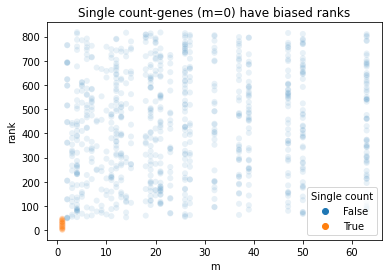

In [9]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('unfilt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Unfiltered, Single count-genes (m=0) have biased ranks')
plt.show()
plt.close()

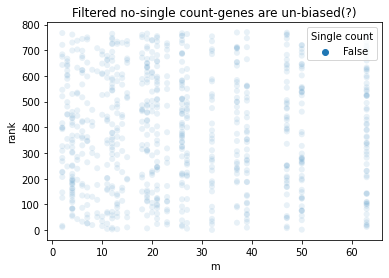

In [12]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('filt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Filtered no-single count-genes are un-biased(?)')
plt.show()
plt.close()

# Formalizing test for punctate bias by gene-count

Now that I've applied the filtering, I can visually see that the bias might be removed

But how can I quantitatively be sure?

I'm going to start by plotting punctate score vs gene/fraction from all cells and see if it "looks correct"

In [62]:
score_df = pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'),ignore_index=True)
score_df

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,radial,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,144.0,0.003484,0.063849
1,radial,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,85.0,0.414634,0.044873
2,radial,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,61.0,0.581882,0.109546
3,radial,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,110.5,0.236934,0.167243
4,radial,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,128.5,0.111498,0.109546
...,...,...,...,...,...,...,...,...,...
4394,radial,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,519.5,-0.348505,0.133159
4395,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,108.5,0.720416,0.166883
4396,radial,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,627.0,-0.628088,0.133159
4397,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,166.5,0.569571,0.166883


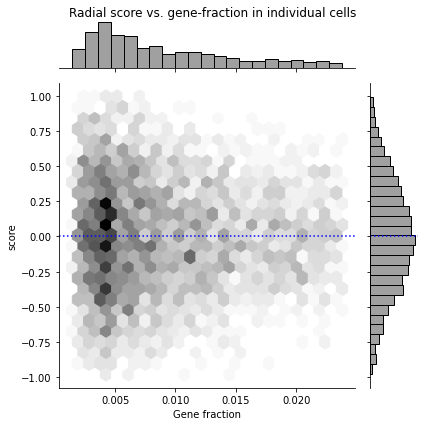

In [63]:
score_df['Gene fraction'] = score_df['num_gene_spots'].div(score_df['num_spots'])
max_frac = score_df['Gene fraction'].quantile(0.8)

p = sns.jointplot(
    x = 'Gene fraction',
    y = 'score',
    kind = 'hex',
    color = 'grey',
    data = score_df[score_df['Gene fraction'].le(max_frac)],
)

p.ax_joint.axhline(0,linestyle='dotted',color='blue')
p.ax_marg_y.axhline(0,linestyle='dotted',color='blue')

#p.ax_joint.set_xlim(0,max_frac)

p.fig.suptitle('Radial score vs. gene-fraction in individual cells')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room #got code from https://stackoverflow.com/questions/60358228/how-to-set-title-on-seaborn-jointplot

plt.show()
plt.close()

the plot does "look" correct, but maybe I can visualize in a different way by binning the gene fractions and plotting CDFs

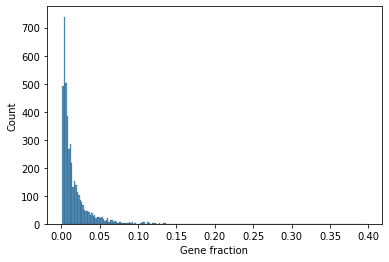

In [44]:
sns.histplot(score_df['Gene fraction'])
plt.show()
plt.close()

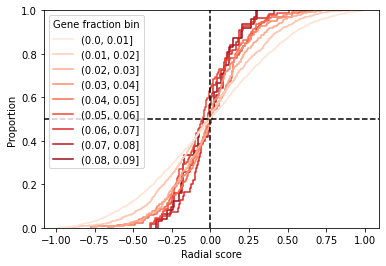

In [65]:
bins = np.arange(0,0.1,0.01)

score_df['Gene fraction bin'] = pd.cut(score_df['Gene fraction'], bins=bins)
ax = sns.ecdfplot(
    x = 'score',
    hue = 'Gene fraction bin',
    palette = 'Reds',
    data = score_df,
)
ax.axhline(0.5, linestyle='dashed', color='black')
ax.axvline(0.0, linestyle='dashed', color='black')
plt.xlabel('Radial score')
plt.show()
plt.close()